
 **Project 2: Prediction of Housing Sale Prices**
 ***

# Problem Statement

You work for the local housing authority. Using the Ames housing dataset, your manager is keen to know how features of a property can determine its sale price. Your manager would also like to know if a better basement (size, quality, exposure etc.) will lead to a higher sale price.

# Background and Data

The data is from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. It contains a range of **81 features** describing a property's characteristics. The target variable of this project will be 'SalePrice'.

There are two datasets included in the `datasets` folder. For the train dataset, I will be perfroming a further train/test split to get train/holdout sets to evaluate my models on (part 2). I will then be predicting sale prices from the test dataset by applying my model on the full train set again.

* [`train.csv`](../datasets/train.csv)
* [`test.csv`](../datasets/test.csv)

# Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import math
import matplotlib.ticker as ticker

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

%matplotlib inline

In [2]:
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 100

In [3]:
train = pd.read_csv(r'../datasets/train.csv')
test = pd.read_csv(r'../datasets/test.csv')

# Data Cleaning

## Initial Checks

In [4]:
train.dtypes.sort_values()

Id                   int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
TotRms AbvGrd        int64
1st Flr SF           int64
Fireplaces           int64
Open Porch SF        int64
Enclosed Porch       int64
3Ssn Porch           int64
Screen Porch         int64
Pool Area            int64
Misc Val             int64
Mo Sold              int64
Yr Sold              int64
Wood Deck SF         int64
Year Remod/Add       int64
SalePrice            int64
Lot Area             int64
PID                  int64
MS SubClass          int64
Overall Qual         int64
Year Built           int64
Overall Cond         int64
Total Bsmt SF      float64
BsmtFin SF 2       float64
Garage Cars        float64
BsmtFin SF 1       float64
Bsmt Full Bath     float64
Bsmt Unf SF        float64
Lot Frontage       float64
Garage Yr Blt      float64
Mas Vnr Area       float64
B

In [5]:
#Check for duplicates

duplicate_rows = train[train.duplicated()]
duplicate_rows.shape

(0, 81)

There are no duplicate rows in the dataset.

In [6]:
#Replace spaces in column names to _

train.columns = train.columns.str.replace(' ','_')
test.columns = test.columns.str.replace(' ','_')

In [7]:
#Convert integer time values to datetime in test set

train['Year_Built'] = pd.to_datetime(train['Year_Built'], format='%Y').dt.year
train['Year_Remod/Add'] = pd.to_datetime(train['Year_Remod/Add'], format='%Y').dt.year
train['Garage_Yr_Blt'] = pd.to_datetime(train['Garage_Yr_Blt'], format='%Y').dt.year
train['Mo_Sold'] = pd.to_datetime(train['Mo_Sold'], format='%m').dt.month
train['Yr_Sold'] = pd.to_datetime(train['Yr_Sold'], format='%Y').dt.year



# #Convert integer time values to datetime in test set

test['Year_Built'] = pd.to_datetime(test['Year_Built'], format='%Y').dt.year
test['Year_Remod/Add'] = pd.to_datetime(test['Year_Remod/Add'], format='%Y').dt.year
test['Garage_Yr_Blt'] = pd.to_datetime(test['Garage_Yr_Blt'], format='%Y').dt.year
test['Mo_Sold'] = pd.to_datetime(test['Mo_Sold'], format='%m').dt.month
test['Yr_Sold'] = pd.to_datetime(test['Yr_Sold'], format='%Y').dt.year

## Drop identification numbers

'Id' and 'PID' are identification numbers which should have no bearing on the target variable 'SalePrice'. I will drop them on both train and test dataset.

In [8]:
train = train.drop(columns=['Id', 'PID'], axis=1)
test = test.drop(columns=['Id', 'PID'], axis=1)

## Data Categorisation

Including the target variable, 'SalePrice', there are **81 features** in this dataset. I have separated them into ordinal, nominal, discrete and continuous categories based on information from the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). I will review and clean the dataset broadly in line with this categorisation.

As a sidenote, the data cleaning/feature engineering is first performed on the train set. However, to make sure that that changes are aligned in the the test set, I will be performing the updates on the test set as we go along the data cleaning/feature engineering process.

|Continuous|Categorical|Ordinal|Discrete|
|---|---|---|---|
|Lot_Frontage|MS_Zoning|Overall_Cond|Bsmt_Full_Bath|
|BsmtFin_SF_1|Street|Overall_Qual|Full_Bath|
|BsmtFin_SF_2|Alley|Lot_Shape|Year_Remod/Add|
|Bsmt_Unf_SF|Land_Contour|Utilities|Kitchen_AbvGr|
|Total_Bsmt_SF|Lot_Config|Land_Slope|TotRms_AbvGrd|
|Garage_Area|Neighborhood|Exter_Qual|Half_Bath|
|Lot_Area|Condition_1|Exter_Cond|Bsmt_Half_Bath|
|Gr_Liv_Area|Condition_2|Bsmt_Qual|Bedroom_AbvGr|
|Low_Qual_Fin_SF|Bldg_Type|Bsmt_Cond|Garage_Yr_Blt|
|1st_Flr_SF|House_Style|Bsmt_Exposure|Fireplaces|
|2nd_Flr_SF|Roof_Style|BsmtFin_Type_1|Mo_Sold|
|Wood_Deck_SF|Roof_Matl|BsmtFin_Type_2|Yr_Sold|
|Open_Porch_SF|Exterior_1st|Heating_QC|Year_Built|
|Enclosed_Porch|Exterior_2nd|Electrical|Garage_Cars|
|3Ssn_Porch|Mas_Vnr_Type|Kitchen_Qual||	
|Screen_Porch|Foundation|Functional||	
|Pool_Area|	Heating|Fireplace_Qu||	
|Mas_Vnr_Area|Central_Air|Garage_Finish||
|Misc_Val|Garage_Type|Garage_Qual||
||Misc_Feature|	Garage_Cond||	
||Sale_Type|Paved_Drive||	
||MS_SubClass|Pool_QC||
|||Fence||

## Check and address null values

In this section, I have reviewed those features with null values and described the processes to clean/impute them. Some of these are standalone features (e.g. 'Pool_QC, 'Misc_Feature'), while several can be reviewed together (e.g. all the 'Garage' or 'Basement' related features). In addition, some of these null values simply mean that the property does not have that feature and would just be updated with 'None'. 

In [9]:
#These are the features with null values

train_null = train.isnull().sum().sort_values(ascending=False)
train_null[train_null > 0]

Pool_QC           2042
Misc_Feature      1986
Alley             1911
Fence             1651
Fireplace_Qu      1000
Lot_Frontage       330
Garage_Finish      114
Garage_Qual        114
Garage_Yr_Blt      114
Garage_Cond        114
Garage_Type        113
Bsmt_Exposure       58
BsmtFin_Type_2      56
Bsmt_Cond           55
Bsmt_Qual           55
BsmtFin_Type_1      55
Mas_Vnr_Area        22
Mas_Vnr_Type        22
Bsmt_Full_Bath       2
Bsmt_Half_Bath       2
Garage_Area          1
Garage_Cars          1
Total_Bsmt_SF        1
Bsmt_Unf_SF          1
BsmtFin_SF_2         1
BsmtFin_SF_1         1
dtype: int64

### Lot Frontage

- There were 330 missing values in the 'Lot Frontage' feature. 
- It is highly unlikely that residential plots have no frontage area (especially in a space rich area like Ames!). Therefore, these missing values should be populated and not dropped.
- There were several features related to 'Lot' and I have chosen two features - 'Lot_Shape' and 'Lot_Config' - to imput the missing values.
- While imputing the mean 'Lot_Frontage' from 'Lot_Shape' is a good start, I thought that it would be more helpful to add an additional layer of complexity by including 'Lot_Config'. 
- For example, a regular shaped lot with an FR3 'Lot_Config' has a mean 'Lot_Frontage' of 81.6 ft, which is almost twice of the mean for a regular shaped lot with a CulDSac 'Lot_Config'. This is unsurprising because a FR3 configuration will have frontage on 3 sides of the property.
- In short, imputing the missing 'Lot_Frontage' via a two-layer classification using 'Lot_Shape' and 'Lot_Config' should give us better mean 'Lot_Frontage' values.

In [10]:
#Populating mean 'Lot_Frontage' based on 'Lot_Shape' and 'Lot_Config'

lot_analysis = train.groupby(['Lot_Shape','Lot_Config'])['Lot_Frontage'].mean().reset_index()
lot_analysis

,Lot_Shape,Lot_Config,Lot_Frontage
0,IR1,Corner,93.300000
1,IR1,CulDSac,57.264151
2,IR1,FR2,73.125000
3,IR1,FR3,96.000000
4,IR1,Inside,71.980952
5,IR2,Corner,82.000000
6,IR2,CulDSac,49.312500
7,IR2,FR2,40.000000
8,IR2,Inside,76.285714
9,IR3,Corner,224.000000


In [11]:
#Apply the mean 'Lot_Frontage' based on 'Lot_Shape' and 'Lot_Config' for all missing values
#For example, a property with IR1 ('Lot_Shape') and Corner ('Lot_Frontage') will be imputed with 93.3 ft for the missing 'Lot_Frontage' value.

train['Lot_Frontage'] = train.apply(
    lambda x: lot_analysis.loc[(lot_analysis['Lot_Shape'] == x['Lot_Shape']) & 
                               (lot_analysis['Lot_Config'] == x['Lot_Config']), 'Lot_Frontage'].values[0] 
                                if(pd.isnull(x['Lot_Frontage'])) else x['Lot_Frontage'], axis=1)

### Garage

- Missing values in 'Garage' features were evaluated together.
- While most 'Garage' features have 114 null values, there is one less null value in 'Garage Type'. Upon investigation, this belonged to index 1712 where all features are null except for the 'Detchd' under 'Garage Type'. 
- There is probably no garage in this property and the 'Garage Type' was incorrectly labelled - I have therefore replaced the 'Detchd' as 'None'.
- For the other 114 'Garage' features, the data dictionary suggests that there is no garage in these properties and I have labelled them as 'None'.

In [12]:
#Unusual behaviour in index 1712 which had missing values in all garage features except for 'Garage_Type'

train.loc[(train['Garage_Cars'].isnull()) | (train['Garage_Area'].isnull()), ['Garage_Cars','Garage_Area', 'Garage_Yr_Blt', 'Garage_Type', 'Garage_Cond', 'Garage_Qual', 'Garage_Finish']]

,Garage_Cars,Garage_Area,Garage_Yr_Blt,Garage_Type,Garage_Cond,Garage_Qual,Garage_Finish
1712,NaN,NaN,NaN,Detchd,NaN,NaN,NaN


In [13]:
#Replacing 'Detchd' in 'Garage_Type' to 'None' 

train.loc[(train['Garage_Cars'].isnull()) & (train['Garage_Type'] == 'Detchd'), [ 'Garage_Type']] = 'None'

In [14]:
#Update all garage features

#Discrete
train['Garage_Cars'] = train['Garage_Cars'].fillna(0)
train['Garage_Yr_Blt'] = train['Garage_Yr_Blt'].fillna(0)

#Continuous
train['Garage_Area'] = train['Garage_Area'].fillna(0)

#Nominal
train['Garage_Type'] = train['Garage_Type'].fillna('None')

#Ordinal
train['Garage_Qual'] = train['Garage_Qual'].fillna('None')
train['Garage_Cond'] = train['Garage_Cond'].fillna('None')
train['Garage_Finish'] = train['Garage_Finish'].fillna('None')

### Basement

- Missing values for 'Basement' features were also evaluated together. There should be around 55 to 58 null values to evaluate.
- Using the same systematic approach used for evaluating 'Garage' null values, I started looking at 'Bsmt Exposure' by filtering null values in that feature **&** 'BsmtFin_Type_1' is not null. This should tell us whether there was a mislabelling or missing value. Rightly so, the null value in 'Bsmt Exposure' is probably a missing field (**not** no basement) as the basement is unfinished. I have replaced it with 'No' which is the mode of the 'BsmtFin Type 1' = 'Unf'.

In [15]:
#3 extra missing values in 'Bsmt_Exposure'

train.loc[(train['Bsmt_Exposure'].isnull()) & (train['BsmtFin_Type_1'].notnull()), ['Bsmt_Exposure', 'Bsmt_Unf_SF', 'Total_Bsmt_SF','BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Qual', 'Bsmt_Cond']]

,Bsmt_Exposure,Bsmt_Unf_SF,Total_Bsmt_SF,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Qual,Bsmt_Cond
1456,NaN,725.0,725.0,Unf,Unf,Gd,TA
1547,NaN,1595.0,1595.0,Unf,Unf,Gd,TA
1997,NaN,936.0,936.0,Unf,Unf,Gd,TA


In [16]:
#Mode of 'Bsmt_Exposure' is 'No'

train.loc[train['BsmtFin_Type_1'] == 'Unf', 'BsmtFin_Type_1'].groupby(train['Bsmt_Exposure']).count()

Bsmt_Exposure
Av     62
Gd     19
Mn     41
No    478
Name: BsmtFin_Type_1, dtype: int64

In [17]:
#Update the 3 missing 'Bsmt_Exposure' with 'No'

train.loc[(train['Bsmt_Exposure'].isnull()) & (train['BsmtFin_Type_1'].notnull()), 'Bsmt_Exposure'] = 'No'

- Similarly, the difference of one null value between 'BsmtFin Type 1' and 'BsmtFin Type 2' is probably due to a unfinished 'BsmtFin Type 2'.
- There are area values in the other 'BsmtFin_SF_2' feature, thereofe I concluded that this is the case and have replaced the null value with 'Unf'

In [18]:
train.loc[(train['BsmtFin_Type_2'].isnull()) & (train['BsmtFin_Type_1'].notnull()), ['Bsmt_Exposure', 'Bsmt_Unf_SF', 'BsmtFin_SF_1', 'BsmtFin_SF_2','Total_Bsmt_SF','BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Qual', 'Bsmt_Cond']]

,Bsmt_Exposure,Bsmt_Unf_SF,BsmtFin_SF_1,BsmtFin_SF_2,Total_Bsmt_SF,BsmtFin_Type_1,BsmtFin_Type_2,Bsmt_Qual,Bsmt_Cond
1147,No,1603.0,1124.0,479.0,3206.0,GLQ,NaN,Gd,TA


In [19]:
#Update the 1 missing 'BsmtFin_Type_2' with 'Unf'

train.loc[(train['BsmtFin_Type_2'].isnull()) & (train['BsmtFin_Type_1'].notnull()), 'BsmtFin_Type_2'] = 'Unf'

- The remaining 55 null values are therefore likely to be 'no basement' properties and I have labelled these as 'None' 

In [20]:
#Update all basement features

#Ordinal
train['BsmtFin_Type_1'] = train['BsmtFin_Type_1'].fillna('None')
train['BsmtFin_Type_2'] = train['BsmtFin_Type_2'].fillna('None')
train['Bsmt_Cond'] = train['Bsmt_Cond'].fillna('None')
train['Bsmt_Qual'] = train['Bsmt_Qual'].fillna('None')
train['Bsmt_Exposure'] = train['Bsmt_Exposure'].fillna('None')

#Discrete
train['Bsmt_Half_Bath'] = train['Bsmt_Half_Bath'].fillna(0)
train['Bsmt_Full_Bath'] = train['Bsmt_Full_Bath'].fillna(0)

#Continuous
train['Bsmt_Unf_SF'] = train['Bsmt_Unf_SF'].fillna(0)
train['BsmtFin_SF_1'] = train['BsmtFin_SF_1'].fillna(0)
train['BsmtFin_SF_2'] = train['BsmtFin_SF_2'].fillna(0)
train['Total_Bsmt_SF'] = train['Total_Bsmt_SF'].fillna(0)

### Masonry

- Missing 22 values for masonry. Based on the data dictionary, these properties probably do not have masonry and I have filled these missing values as 'None'

In [21]:
#Update all masonry features

#Nominal
train['Mas_Vnr_Type'] = train['Mas_Vnr_Type'].fillna('None')

#Continuous
train['Mas_Vnr_Area'] = train['Mas_Vnr_Area'].fillna(0)

### Pool QC, Fence, Fireplace QC, Misc Features, Alley

- The remaining missing values are either ordinal or nominal features
- For these features ('Pool QC', 'Fence', 'Fireplace Qu', 'Misc Feature', 'Alley'), I have compared these with the corresponding features to make conclusions that these properties probably do not have these features. For example, if there is no pool, 'Pool Area' should be 0, and since that is true, I can confidently fill the corresponding 'Pool QC' field with 'None'.

In [22]:
#ordinal
train['Pool_QC'] = train['Pool_QC'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')
train['Fireplace_Qu'] = train['Fireplace_Qu'].fillna('None')

#Nominal
train['Misc_Feature'] = train['Misc_Feature'].fillna('None')
train['Alley'] = train['Alley'].fillna('None')

### Align null value changes in train dataset with test dataset 

In [23]:
#These are the features with null values in the test set

test_null = test.isnull().sum().sort_values(ascending=False)
test_null[test_null > 0]

Pool_QC           875
Misc_Feature      838
Alley             821
Fence             707
Fireplace_Qu      422
Lot_Frontage      160
Garage_Yr_Blt      45
Garage_Finish      45
Garage_Qual        45
Garage_Cond        45
Garage_Type        44
BsmtFin_Type_2     25
Bsmt_Cond          25
Bsmt_Exposure      25
BsmtFin_Type_1     25
Bsmt_Qual          25
Electrical          1
Mas_Vnr_Type        1
Mas_Vnr_Area        1
dtype: int64

- To avoid any information leakage into the test set, I will use the means from the train dataset to impute the missing 'Lot Frontage' values in the test set.
- However, there are new 'Lot_Shape' and 'Lot_Config' combinations in the test set that were not in the train set.
- Fortunately, this is only one entry and I have imputed this with a mean from 'CulDSac' (since lots in this configuration, regardless of the shape, have quite similar frontage area).

In [24]:
#Similar mean 'Lot_Frontage' calculations from above

lot_analysis = train.groupby(['Lot_Shape','Lot_Config'])['Lot_Frontage'].mean().reset_index()
lot_analysis

,Lot_Shape,Lot_Config,Lot_Frontage
0,IR1,Corner,93.300000
1,IR1,CulDSac,57.264151
2,IR1,FR2,73.125000
3,IR1,FR3,96.000000
4,IR1,Inside,71.980952
5,IR2,Corner,82.000000
6,IR2,CulDSac,49.312500
7,IR2,FR2,40.000000
8,IR2,Inside,76.285714
9,IR3,Corner,224.000000


In [25]:
#Update null 'Lot_Frontage' values in test set with calculations from the train set

update_check_lots = test[['Lot_Frontage', 'Lot_Shape', 'Lot_Config']].merge(lot_analysis, how="left", left_on=['Lot_Shape', 'Lot_Config'], right_on=['Lot_Shape', 'Lot_Config'])

test['Lot_Frontage'] = update_check_lots.apply(
    lambda x : x['Lot_Frontage_y'] 
    if pd.isnull(x['Lot_Frontage_x']) else x['Lot_Frontage_x'], axis=1 ) 

In [26]:
#New combination of 'Lot_Config', 'Lot_Shape' in test set not seen in train set

test.loc[test['Lot_Frontage'].isnull(),['Lot_Frontage', 'Lot_Shape', 'Lot_Config']]

,Lot_Frontage,Lot_Shape,Lot_Config
650,NaN,IR3,CulDSac


In [27]:
#Update this missing value with mean 'Lot_Frontage' of properties with 'CulDSac' confirguration

test.loc[test['Lot_Frontage'].isnull(), 'Lot_Frontage'] = train.loc[train['Lot_Config'] == 'CulDSac', 'Lot_Frontage'].mean()

In [28]:
#Update 'Garage' missing values

test['Garage_Qual'] = test['Garage_Qual'].fillna('None')
test['Garage_Cond'] = test['Garage_Cond'].fillna('None')
test['Garage_Finish'] = test['Garage_Finish'].fillna('None')
test['Garage_Type'] = test['Garage_Type'].fillna('None')
test['Garage_Yr_Blt'] = test['Garage_Yr_Blt'].fillna(0)

In [29]:
#Update 'Basement' missing values

test['BsmtFin_Type_1'] = test['BsmtFin_Type_1'].fillna('None')
test['BsmtFin_Type_2'] = test['BsmtFin_Type_2'].fillna('None')
test['Bsmt_Cond'] = test['Bsmt_Cond'].fillna('None')
test['Bsmt_Qual'] = test['Bsmt_Qual'].fillna('None')
test['Bsmt_Exposure'] = test['Bsmt_Exposure'].fillna('None')

In [30]:
#Update other features

test['Mas_Vnr_Area'] = test['Mas_Vnr_Area'].fillna(0)
test['Mas_Vnr_Type'] = test['Mas_Vnr_Type'].fillna('None')
test['Fireplace_Qu'] = test['Fireplace_Qu'].fillna('None')
test['Pool_QC'] = test['Pool_QC'].fillna('None')
test['Misc_Feature'] = test['Misc_Feature'].fillna('None')
test['Alley'] = test['Alley'].fillna('None')
test['Fence'] = test['Fence'].fillna('None')
test['Electrical'] = test['Electrical'].fillna('SBrkr') #filled with the mode imputed from train set

## Ordinal Features - Mapped to numeric 

In this section, I will map ordinal features from string to numeric format. I will treat these features as ordinal rather than catergorical in my model. 'Overall_Cond' and 'Overall_Qual' are already in numeric format, therefore good to use as they are.

### Update ordinal features in train dataset

In [31]:
train_ordinal = train[['Overall_Cond',
                       'Overall_Qual',
                       'Lot_Shape',
                       'Utilities',
                       'Land_Slope',
                       'Exter_Qual',
                       'Exter_Cond',
                       'Bsmt_Qual',
                       'Bsmt_Cond',
                       'Bsmt_Exposure',
                       'BsmtFin_Type_1',
                       'BsmtFin_Type_2',
                       'Heating_QC',
                       'Electrical',
                       'Kitchen_Qual',
                       'Functional',
                       'Fireplace_Qu',
                       'Garage_Finish',
                       'Garage_Qual',
                       'Garage_Cond',
                       'Paved_Drive',
                       'Pool_QC',
                       'Fence']]

In [32]:
#Assigned based on irregularity. 3 being regular

train['Lot_Shape'] = train['Lot_Shape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})

In [33]:
#Assigned based on types of utilties available . 2 being all utilities available

train['Utilities'] = train['Utilities'].map({'AllPub': 2, 'NoSewr': 1, 'NoSeWa': 0})

In [34]:
#Assigned based on steepness. 2 being gentle

train['Land_Slope'] = train['Land_Slope'].map({'Gtl': 2, 'Mod': 1, 'Sev': 0})

In [35]:
#Assigned based on quality. 0 being Average/Typical

train['Exter_Qual'] = train['Exter_Qual'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
train['Exter_Cond'] = train['Exter_Cond'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})

In [36]:
#Having a basement should be considered a plus, therefore I have applied 0 to 'no basement'

train['Bsmt_Qual'] = train['Bsmt_Qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
train['Bsmt_Cond'] = train['Bsmt_Cond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

train['BsmtFin_Type_1'] = train['BsmtFin_Type_1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
train['BsmtFin_Type_2'] = train['BsmtFin_Type_2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})

#As mentioned, having a basement should be considered better than 'no basement'. 
#Therefore, having one with 'no exposure' should still be better than 'no basement'
train['Bsmt_Exposure'] = train['Bsmt_Exposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})

In [37]:
#Assigned based on quality. 0 being Average/Typical

train['Heating_QC'] = train['Heating_QC'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})

In [38]:
#Assigned based on quality. 4 being SBrkr (mode)

train['Electrical'] = train['Electrical'].map({'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})

In [39]:
#Assigned based on quality. 0 being Average/Typical

train['Kitchen_Qual'] = train['Kitchen_Qual'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})

In [40]:
#Assigned based on quality. 7 being Typical (mode)

train['Functional'] = train['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})

In [41]:
#Like having a basement, I have considered having a fireplace a plus, therefore I have applied 0 to 'no fireplace'

train['Fireplace_Qu'] = train['Fireplace_Qu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

In [42]:
#Like having a basement, I have considered having a garage a plus, therefore I have applied 0 to 'no garage'

train['Garage_Qual'] = train['Garage_Qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
train['Garage_Cond'] = train['Garage_Cond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

train['Garage_Finish'] = train['Garage_Finish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0})

In [43]:
#Assigned based on how much it is paved. 2 being paved

train['Paved_Drive'] = train['Paved_Drive'].map({'Y': 2, 'N': 1, 'P': 0})

In [44]:
#Like having a basement, I have considered having a pool a plus, therefore I have applied 0 to 'no pool'

train['Pool_QC'] = train['Pool_QC'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0})

In [45]:
#I have considered having a fence a plus since it is related to the level of privacy. Therefore, I have applied 0 to 'no fence'

train['Fence'] = train['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0})

### Align ordinal features update in train dataset with test dataset

In [46]:
#Map ordinal features to numeric

test['Lot_Shape'] = test['Lot_Shape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
test['Utilities'] = test['Utilities'].map({'AllPub': 2, 'NoSewr': 1, 'NoSeWa': 0})
test['Land_Slope'] = test['Land_Slope'].map({'Gtl': 2, 'Mod': 1, 'Sev': 0})
test['Exter_Qual'] = test['Exter_Qual'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
test['Exter_Cond'] = test['Exter_Cond'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
test['Bsmt_Qual'] = test['Bsmt_Qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
test['Bsmt_Cond'] = test['Bsmt_Cond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
test['BsmtFin_Type_1'] = test['BsmtFin_Type_1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
test['BsmtFin_Type_2'] = test['BsmtFin_Type_2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
test['Bsmt_Exposure'] = test['Bsmt_Exposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
test['Heating_QC'] = test['Heating_QC'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
test['Electrical'] = test['Electrical'].map({'SBrkr': 4, 'FuseA': 3, 'FuseF': 2, 'FuseP': 1, 'Mix': 0})
test['Kitchen_Qual'] = test['Kitchen_Qual'].map({'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2})
test['Functional'] = test['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})
test['Fireplace_Qu'] = test['Fireplace_Qu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
test['Garage_Qual'] = test['Garage_Qual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
test['Garage_Cond'] = test['Garage_Cond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
test['Garage_Finish'] = test['Garage_Finish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0})
test['Paved_Drive'] = test['Paved_Drive'].map({'Y': 2, 'N': 1, 'P': 0})
test['Pool_QC'] = test['Pool_QC'].map({'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0})
test['Fence'] = test['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0})

## Nominal Features - One Hot Encoding

In this section, I will one hot encode the nominal features using sklearn's `OneHotEncoder`. I will fit and transform on the train dataset, and then transform on the test dataset.

In [47]:
train_nominal = train[['MS_Zoning', 
                 'Street', 
                 'Alley',
                 'Land_Contour',
                 'Lot_Config',
                 'Neighborhood',
                 'Condition_1',
                 'Condition_2',
                 'Bldg_Type',
                 'House_Style',
                 'Roof_Style',
                 'Roof_Matl',
                 'Exterior_1st',
                 'Exterior_2nd',
                 'Mas_Vnr_Type',
                 'Foundation',
                 'Heating',
                 'Central_Air',
                 'Garage_Type',
                 'Misc_Feature',
                 'Sale_Type',
                 'MS_SubClass']]

In [48]:
test_nominal = train[['MS_Zoning', 
                 'Street', 
                 'Alley',
                 'Land_Contour',
                 'Lot_Config',
                 'Neighborhood',
                 'Condition_1',
                 'Condition_2',
                 'Bldg_Type',
                 'House_Style',
                 'Roof_Style',
                 'Roof_Matl',
                 'Exterior_1st',
                 'Exterior_2nd',
                 'Mas_Vnr_Type',
                 'Foundation',
                 'Heating',
                 'Central_Air',
                 'Garage_Type',
                 'Misc_Feature',
                 'Sale_Type',
                 'MS_SubClass']]

In [49]:
#Function to one hot encode on both train and test datasets

def one_hot_encoding(train_nominal_data, test_nominal_data):
    '''Function to one hot encode nominal features'''
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for cat in range(len(train_nominal_data.columns)):
        cat_train_enc = enc.fit_transform(train_nominal_data[[train_nominal_data.columns[cat]]])
        cat_train_df = pd.DataFrame(cat_train_enc, columns=list(enc.categories_[0]))
        cat_train_df = cat_train_df.iloc[:, 1:]
        train[cat_train_df.columns] = cat_train_df

        cat_test_enc = enc.transform(test_nominal_data[[test_nominal_data.columns[cat]]])
        cat_test_df = pd.DataFrame(cat_test_enc, columns=list(enc.categories_[0]))
        cat_test_df = cat_test_df.iloc[:, 1:]
        test[cat_test_df.columns] = cat_test_df

In [50]:
one_hot_encoding(train_nominal,test_nominal)

In [51]:
#drop original columns

train = train.drop(columns=train_nominal)
test = test.drop(columns=test_nominal)

In [52]:
#Check to make sure changes applied so far are as expected

print('train shape check:', train.shape)
print('test shape check:', test.shape)

train shape check: (2051, 184)
test shape check: (879, 183)


## Feature Engineering

After applying the necessary data cleaning/feature binarisation above, I will proceed to perform some feature engineering to see if I can possibly improve the fit of my model. Firstly, I will create some polynomial features/interaction terms using sklearn's `PolynomialFeatures`. Secondly, I will explore some feature enhancements such as combining/dropping similar fields.

### Polynomial Features / Interaction Terms

In [53]:
features = list(train.drop(columns=['SalePrice']).columns)
features = list(map(str, features))
X = train.drop(columns=['SalePrice'])

In [54]:
#Apply sklearn's PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

In [55]:
poly_features = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))
poly_corr = poly_features.corrwith(train['SalePrice']).sort_values(ascending=False)

In [56]:
poly_corr.head()

Overall_Qual Gr_Liv_Area    0.837152
Overall_Qual^2              0.825539
Overall_Qual Garage_Cars    0.819935
Bsmt_Qual Gr_Liv_Area       0.814206
Overall_Qual Garage_Area    0.813247
dtype: float64

Due to the large number of existing features, we end up with more than 17,000 features after the polynomial features transformation. I will be selecting **'Overall_Qual Gr_Liv_Area', 'Overall_Qual^2', 'Bsmt_Qual Gr_Liv_Area'** and **'Overall_Qual Garage_Area'** to add to my model since they have the highest correlation with **'SalePrice'**.

I have also written a subplot function to help me visualise the correlation of these interaction terms with the target variable 'SalePrice'.

In [57]:
#Add selected polynominal features/interaction terms to train set

poly_features_add = poly_features[['Overall_Qual Gr_Liv_Area', 'Overall_Qual^2', 'Bsmt_Qual Gr_Liv_Area', 'Overall_Qual Garage_Area']]
train = train.join(poly_features_add)

In [58]:
#Function for plotting 

def choose_subplot_dimensions(k):
    '''Function to set subplot dimensions - # of plots changes accordingly to # of columns'''    
    
    #k is the number of columns in the dataset
    if k < 2:
        return k, 1
    elif k < 11:
        return math.ceil(k/2), 2
    else:
        # Plot only max 3 columns in the output
        return math.ceil(k/3), 3


def generate_subplots(k, row_wise=False):
    '''Function to generate the plots'''    
    
    nrow, ncol = choose_subplot_dimensions(k)
    # X and share Y parameters will be fed in below:
    figure, axes = plt.subplots(nrow, ncol,
                                sharex=False,
                                sharey=False,
                                figsize=(15,15))

    # Check if it's an array. If only one plot, it's an axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        #Traversal: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))
        
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)


        axes = axes[:k]
        return figure, axes

In [59]:
#Function to plot scatterplot 

def plot_scatterplot(sub_dataset, y):
    '''Function to plot scatterplot using the subplot functions defined above'''
    
    figure, axes = generate_subplots(len(sub_dataset.columns), row_wise=True)
    for parameter, ax in zip(sub_dataset.columns, axes):
        sns.scatterplot(ax = ax, y=y, x=sub_dataset[parameter])
        ax.set_title(label="{} vs SalePrice".format(parameter))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K')) 
        #converted y-axis to thousands K for easy reading
        
    plt.tight_layout()
    plt.show()

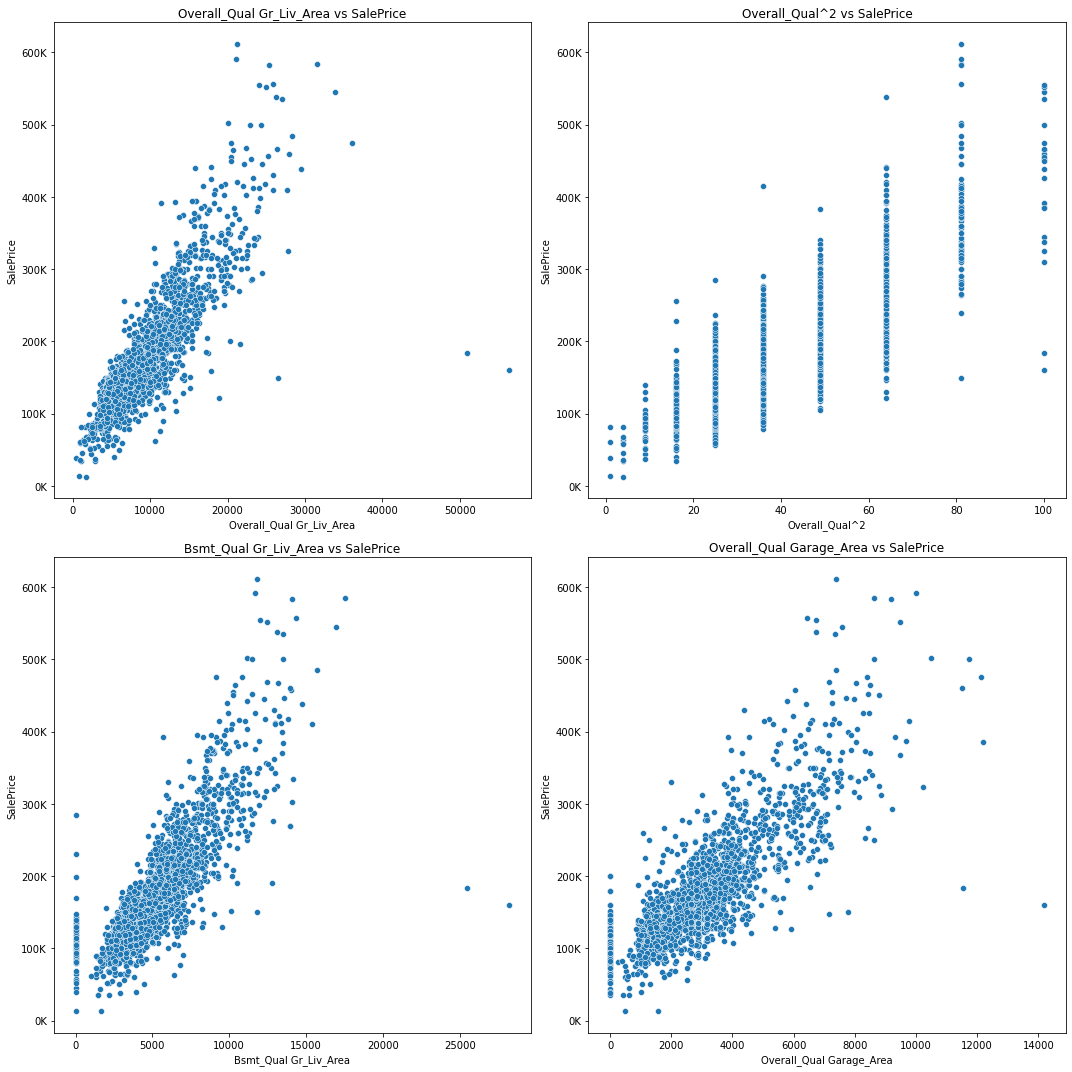

In [60]:
#Correlation between polynomial features with 'SalePrirce'

plot_scatterplot(poly_features_add, train['SalePrice'])

### Other Feature Enhancements

As per the check below, 'Total_Bsmt_SF' is the sum of 'Bsmt_Unf_SF' + 'BsmtFin_SF_1' + 'BsmtFin_SF_2'. Therefore, I will drop the 'Bsmt_Unf_SF', 'BsmtFin_SF_1', 'BsmtFin_SF_2' columns.

In [61]:
train['bsmt_size_check'] = train['Total_Bsmt_SF'] - train[['Bsmt_Unf_SF', 'BsmtFin_SF_1', 'BsmtFin_SF_2']].sum(axis=1) 
train['bsmt_size_check'].sum()

0.0

In [62]:
train = train.drop(columns=['Bsmt_Unf_SF', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'bsmt_size_check'])

As per the check below, 'Gr_Liv_Area' is the sum of '1st_Flr_SF' + '2nd_Flr_SF' + 'Low_Qual_Fin_SF'. Therefore, I will drop the 1st_Flr_SF', '2nd_Flr_SF', 'Low_Qual_Fin_SF' columns.

In [63]:
train['Gr_Liv_Area_check'] = train['Gr_Liv_Area'] - train[['1st_Flr_SF', '2nd_Flr_SF','Low_Qual_Fin_SF']].sum(axis=1) 
train['Gr_Liv_Area_check'].sum()

0

In [64]:
train = train.drop(columns=['1st_Flr_SF', '2nd_Flr_SF','Low_Qual_Fin_SF','Gr_Liv_Area_check'])

### Align feature engineering changes in train dataset with test dataset

In [65]:
#Changes in polynomial features/interaction terms
test['Overall_Qual Gr_Liv_Area'] = test['Overall_Qual'] * test['Gr_Liv_Area']
test['Overall_Qual^2'] = test['Overall_Qual'] * test['Overall_Qual']
test['Bsmt_Qual Gr_Liv_Area'] = test['Bsmt_Qual'] * test['Gr_Liv_Area']
test['Overall_Qual Garage_Area'] = test['Overall_Qual'] * test['Garage_Area']

#Dropping columns from feature enhancement steps
test = test.drop(columns=['Bsmt_Unf_SF', 'BsmtFin_SF_1', 'BsmtFin_SF_2'])
test = test.drop(columns=['1st_Flr_SF', '2nd_Flr_SF','Low_Qual_Fin_SF'])

## Check for outliers

After performing the columnal changes based on the feature types, I will explore outliers by performing some EDA
on the continuous variables.

- In this section, I checked for outliers by plotting 'SalePrice' against the continuous variables. 
- I have wrote a function to plot multiple subplots - details are in the comments within the function


In [66]:
#These are the continuous variables

train_continuous = train[['Lot_Frontage','Total_Bsmt_SF','Garage_Area','Lot_Area','Gr_Liv_Area','Wood_Deck_SF','Open_Porch_SF','Enclosed_Porch','3Ssn_Porch','Screen_Porch','Pool_Area','Mas_Vnr_Area','Misc_Val']]

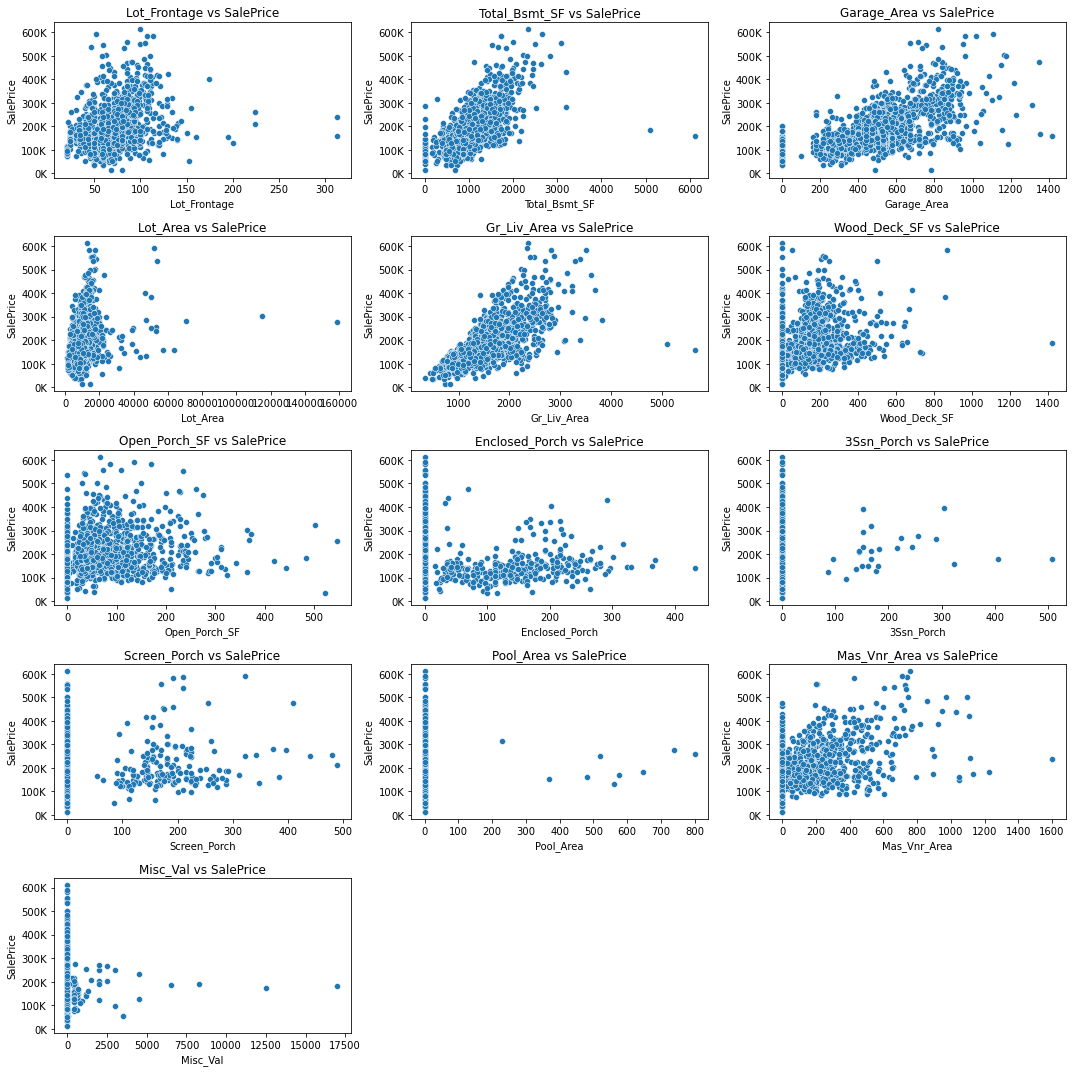

In [67]:
#Using the subplot and scatterplot functions, these are the correlation between SalePrice and continuous variables.

plot_scatterplot(train_continuous, train['SalePrice'])

From the above, it looks like there are two distinct outliers in 'SalePrice'. From the data dictionary, this should be the two properties with 'Gr_Liv_Area' that are > 4000 sqft. I have decided to drop them since they will skew the results as most properties are significantly smaller at <3000 sqft.

In [68]:
train_continuous.loc[(train_continuous['Gr_Liv_Area'] > 4000), :]

,Lot_Frontage,Total_Bsmt_SF,Garage_Area,Lot_Area,Gr_Liv_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Mas_Vnr_Area,Misc_Val
960,313.0,6110.0,1418.0,63887,5642,214,292,0,0,0,480,796.0,0
1885,128.0,5095.0,1154.0,39290,5095,546,484,0,0,0,0,1224.0,17000


In [69]:
#Remove the >4000 in 'Gr_Liv_Area' as per data dictionary

train = train.drop(train[train['Gr_Liv_Area'] > 4000].index)

## Sidenote: Log transformation of Sale Price

I am cognizant that the target variable should follow a normal distribution when performing a linear regression. To check, I have plotted 'SalePrice' and a log 'SalePrice' to compare the distribution. While I would not definitively conclude that the 'SalePrice' follows a normal distribution, it is fairly close to the log transformed one. For ease of modelling and upload into the Kaggle competition, I will continue using the 'SalePrice' variable as it is.

In [70]:
#Log transfrom 'SalePrice' to 'Ln_SalePrice'

log_train_saleprice = np.log(train['SalePrice'])
train['Ln_SalePrice'] = log_train_saleprice

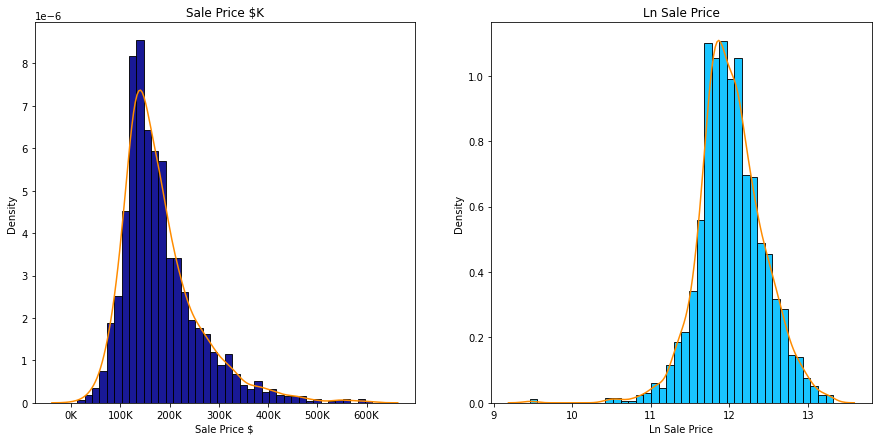

In [71]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
sns.histplot(train['SalePrice'], bins=40, ax=ax1, color='Darkblue', alpha=0.9, stat="density")
sns.kdeplot(train['SalePrice'], color='darkorange')
ax1.set_title('Sale Price $K')
ax1.set_xlabel('Sale Price $')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax2 = fig.add_subplot(1,2,2)
sns.histplot(log_train_saleprice, bins=40, ax=ax2, color='deepskyblue', alpha=0.9, stat="density")
sns.kdeplot(log_train_saleprice, color='darkorange')
ax2.set_xlabel('Ln Sale Price')
ax2.set_title('Ln Sale Price');

## Exporting updated train and test datasets

In [72]:
#Final check to make sure changes applied so far are as expected

print('train shape check:', train.shape)
print('test shape check:', test.shape)

train shape check: (2049, 183)
test shape check: (879, 181)


In [73]:
#The updated train dataset will be named as 'full_training_set.csv'

train.to_csv(r'../datasets/full_training_set.csv', index=False)

In [74]:
#The updated test dataset will be named as 'full_training_set.csv'

test.to_csv(r'../datasets/full_test_set.csv', index=False)

<br>

**We will proceed to modelling in the next part of this project!**